# COVID-19
-----

## TOC:
* [Database casi in Italia e nel mondo](#s1)
    - [Caricamento dati in un *Pandas Dataframe*](#s1.1)
* [Modello epidemico Susceptible-Infected-Recovered (SIR)](#s2)
    - [Approsimazione dei parametri $\beta$ e $\gamma$](#s2.1)
    - [Risoluzione del modello](#s2.2)
    - [Costruzione funzione generica](#s2.3)
* [Applicazione al Italia](#s3)
* [Applicazione al Mondo](#s4)
* [Applicazione agli USA](#s5)
---

## Database casi in Italia e nel mondo <a class="anchor" id="s1"></a>

#### *Protezione Civile*

In [1]:
!rmdir /S /Q COVID-19

In [2]:
!git clone https://github.com/pcm-dpc/COVID-19.git

Cloning into 'COVID-19'...


#### *Johns Hopkins University*

In [3]:
!rmdir /S /Q COVID-19_JHU

In [4]:
!git clone https://github.com/CSSEGISandData/COVID-19.git COVID-19_JHU

Cloning into 'COVID-19_JHU'...
Updating files:  97% (211/217)
Updating files:  98% (213/217)
Updating files:  99% (215/217)
Updating files: 100% (217/217)
Updating files: 100% (217/217), done.


In [5]:
import time
time.sleep(30)

### Caricamento dati in un *Pandas Dataframe* <a class="anchor" id="s1.1"></a>

In [6]:
import pandas as pd
import numpy as np
from os import path
from glob import glob

Italia

In [7]:
data_path = path.join("COVID-19", "dati-andamento-nazionale")
file_pattern = "dpc-covid19-ita-andamento-nazionale-2020[0-9][0-9][0-9][0-9].csv"
list_of_files = [file for file in glob(path.join(data_path, file_pattern))]
dtype_ = dict(ricoverati_con_sintomi = np.dtype('>i4'),
             terapia_intensiva = np.dtype('>i4'),
             totale_ospedalizzati = np.dtype('>i4'),
             isolamento_domiciliare = np.dtype('>i4'),
             totale_attualmente_positivi = np.dtype('>i4'), 
             nuovi_attualmente_positivi = np.dtype('>i4'),
             dimessi_guariti = np.dtype('>i4'), 
             deceduti = np.dtype('>i4'), 
             totale_casi = np.dtype('>i4'), 
             tamponi = np.dtype('>i4')) 
df = pd.concat([pd.read_csv(file, parse_dates=[0]) for file in list_of_files])
df['data'] = pd.to_datetime(df['data'], unit="ns")
#df = df.astype(dtype_)
df = df.reset_index(drop=True)

df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
40,2020-04-04 17:00:00,ITA,29010,3994,33004,55270,88274,2886,4805,20996,15362,124632,657224,NaN,NaN
41,2020-04-05 17:00:00,ITA,28949,3977,32926,58320,91246,2972,4316,21815,15887,128948,691461,NaN,NaN
42,2020-04-06 17:00:00,ITA,28976,3898,32874,60313,93187,1941,3599,22837,16523,132547,721732,NaN,NaN
43,2020-04-07 17:00:00,ITA,28718,3792,32510,61557,94067,880,3039,24392,17127,135586,755445,NaN,NaN
44,2020-04-08 17:00:00,ITA,28485,3693,32178,63084,95262,1195,3836,26491,17669,139422,807125,NaN,NaN


Mondo

In [8]:
data_path_T = path.join("COVID-19_JHU", "csse_covid_19_data", "csse_covid_19_time_series","time_series_covid19_confirmed_global.csv")
data_path_D = path.join("COVID-19_JHU", "csse_covid_19_data", "csse_covid_19_time_series","time_series_covid19_deaths_global.csv")
data_path_R = path.join("COVID-19_JHU", "csse_covid_19_data", "csse_covid_19_time_series","time_series_covid19_recovered_global.csv")

# load & pre-processing
def smerge(x): 
    return x[x.notnull()].values.sum()
dataframes = {}
for i, file in enumerate([data_path_T, data_path_D, data_path_R]) :
    dataframes[i] = pd.read_csv(file)
    dataframes[i] = dataframes[i].T
    dataframes[i].columns = dataframes[i].iloc[1]
    dataframes[i] = dataframes[i].drop(dataframes[i].index[:4], axis=0)
    dataframes[i] = dataframes[i].groupby(level=0, axis=1).apply(lambda x: x.apply(smerge, axis=1))
    dataframes[i]["date"] = pd.to_datetime(dataframes[i].index, format='%m/%d/%Y', infer_datetime_format=True).values
    dataframes[i] = dataframes[i].set_index('date')
    
df_jhu_T, df_jhu_D, df_jhu_R = [dataframes[0], dataframes[1], dataframes[2]]
df_jhu_R

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-03,10,89,62,16,1,0,266,43,649,2022,...,108,208,68,25,52,85,21,0,2,0
2020-04-04,10,99,90,21,2,0,279,43,701,2507,...,125,215,93,25,52,90,21,0,2,0
2020-04-05,15,104,90,26,2,0,280,57,757,2998,...,144,229,93,30,52,90,25,0,3,0


In [9]:
df_jhu_T, df_jhu_D, df_jhu_R = [dataframes[0], dataframes[1], dataframes[2]]

In [10]:
df_jhu_R.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2020-04-03,10,89,62,16,1,0,266,43,649,2022,...,108,208,68,25,52,85,21,0,2,0
2020-04-04,10,99,90,21,2,0,279,43,701,2507,...,125,215,93,25,52,90,21,0,2,0
2020-04-05,15,104,90,26,2,0,280,57,757,2998,...,144,229,93,30,52,90,25,0,3,0
2020-04-06,18,116,90,31,2,0,325,62,1080,3463,...,167,287,104,30,65,95,24,0,5,0
2020-04-07,18,131,113,39,2,0,338,87,1080,4046,...,186,325,150,30,65,123,42,0,7,0


## Modello epidemico Susceptible-Infected-Recovered (SIR) <a class="anchor" id="s2"></a>

Nel 1927 A. G. McKendrick and W. O Kermack [1] hanno proposto il seguente modello, basato da 3 variabili: $S$: Suscettibili (persone che possono essere infettate), $I$: Infetti (persone infettate), $R$: Guraiti (persone Guarite).
E useremo la formulazione e proposta da [Harko et al.](https://arxiv.org/pdf/1403.2160.pdf)

$\dfrac{dS}{dt} = -\beta S(t)I(t) $;

$\dfrac{dI}{dt} = \beta S(t)I(t)  - \gamma I(t)$;

$\dfrac{dR}{dt} = \gamma I(t) $;

$ S + I + R = N $.

Dove $N$ è la popolazione totale, $\gamma > 0$ è il rateo di gurigione,  $\beta > 0$ è il rateo di infezione(infettività). Quest'ultimo in caso di epidemia libera di agire è solitamente costante, ma visto le misure restrittive è corretto considerarlo variabile e possiamo estrapolarlo dai dati attuali:

$\beta  = - \dfrac{dS/dt}{S(t)} $;

$\gamma  = \dfrac{dR/dt}{I(t)} $.


[1] W. O. Kermack and A. G. McKendrick, Contribution to the mathematical theory of epidemics, Proc. Roy. Soc. Lond A 115, 700-721 (1927).

In [11]:
N = 60550075 # popolazione italiana 2019
R = df.dimessi_guariti.values + df.deceduti.values  # NOTA: per tenere conto dei decessi (non 
                                                    # inclusi nel modello) li consideriamo come
                                                    # guariti altrimenti la relazione S+I+R=N 
                                                    # non è più valida
I = df.totale_positivi.values
S = N * np.ones(len(R)) - R - I

### Approsimazione dei parametri $\beta$ e $\gamma$ <a class="anchor" id="s2.1"></a>

In [12]:
from scipy.optimize import curve_fit
from scipy import stats

def cent_dif(t, x):
    """
    Calcola la derivata della curva con il metodo della differenza finita centrata
    """
    dx = x[2:]-x[:-2]
    dt = t[2:]-t[:-2]
    return t[1:-1], dx/dt

def β_ramp(t, m, t0, constant=False, β_min=0):
    """
    Approssima l'infettività β con una fuzione rampa
    """
    if not constant:
        β = m*(t-t0)
        if isinstance(t, float):
            if β < β_min :
                β = β_min
        else:
            β[β < β_min] = β_min
    else: 
        if isinstance(t, float):
            β = constant
        else:
            β = np.ones(t.shape) * constant
        
        
    return β


t = ((df.data.values -df.data.values[0]) / (24*60*60*1e9)).astype(int) # [d]
t_, dRdt = cent_dif(t, R)
_, dSdt = cent_dif(t, S)
_, dIdt = cent_dif(t, I)
γ = dRdt/I[1:-1]
β = -dSdt/S[1:-1]/I[1:-1]
z = 1 # %68 (1.96 %95)
γ_mean, δγ = [γ.mean(), z*γ.std()]
popt_ramp, pcov_ramp = curve_fit(β_ramp, t_, β, method='lm', p0=[-1, 50])
m_r, t0_r = popt_ramp
δm_r, δt0_r = z*np.sqrt(np.diag(pcov_ramp))

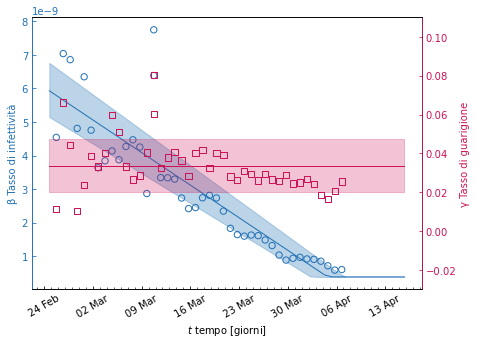

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.dates import (DateFormatter, DayLocator, WeekdayLocator)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

β_min_ = max(β)/20
fig1 = plt.figure(figsize=(7,5))
ax = fig1.add_subplot('111')
ax_twin = ax.twinx()
t_plot = np.linspace(-0,t_[-1]+9)
t_date = df.data.values[0] + (t_) * np.timedelta64(1*24*60*60, 's')
t_plot_date = df.data.values[0] + (t_plot-t_plot[0]) * np.timedelta64(1*24*60*60, 's')
ax.scatter(t_date, β, s=40, fc='None', ec='#2171b5')
ax_twin.scatter(t_date, γ, s=40, fc='None', marker='s', ec='#ce1256')

ax.plot(t_plot_date, β_ramp(t_plot, m_r, t0_r, β_min=β_min_), lw=1, color='#2171b5')
ax.fill_between(t_plot_date, β_ramp(t_plot, m_r+δm_r, t0_r-δt0_r, β_min=β_min_), β_ramp(t_plot, m_r-δm_r, t0_r+δt0_r, β_min=β_min_),
                lw=1, color='#2171b5', alpha=.3)
ax_twin.plot(t_plot_date[[0,-1]], [γ_mean, γ_mean], lw=1, color='#ce1256')
ax_twin.fill_between(t_plot_date[[0,-1]], [γ_mean-δγ, γ_mean-δγ], [γ_mean+δγ, γ_mean+δγ], lw=1, color='#ce1256',
                     alpha=.25)

ax.set_ylabel('β Tasso di infettività')
ax.set_xlabel("$t$ tempo [giorni]")
ax.yaxis.label.set_color('#2171b5')
ax.spines["left"].set_edgecolor('#2171b5')
ax_twin.spines["left"].set_edgecolor('#2171b5')
ax.tick_params(axis='y', colors='#2171b5')
ax_twin.set_ylim([-0.03,0.11])
ax_twin.set_ylabel('γ Tasso di guarigione')
ax_twin.yaxis.label.set_color('#ce1256')
ax_twin.spines["right"].set_edgecolor('#ce1256')
ax_twin.tick_params(axis='y', colors='#ce1256')
t_mode_date = t_[-1] + (t_plot-t_plot[0]) * np.timedelta64(1, 'D')
formatter = DateFormatter('%d %b')
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.xaxis.set_minor_locator(DayLocator())
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=0))

plt.show()

### Risoluzione del modello <a class="anchor" id="s2.2"></a>

Risoluzione del sitema di ODE con il metodo eslicito di Runge-Kutta di ordine 5(4)

In [14]:
def dvdt_SIR(t, v, m, t0, γ, β_const=False, β_min=0):
    """
    fuzione che calcola la derivata per S, I e R per ogni sitante t
    """
    β = β_ramp(t, m, t0, constant=β_const, β_min=β_min)
    dvdt = [-β*v[0]*v[1],
            β*v[0]*v[1] - γ*v[1],
            γ*v[1]]
    return dvdt

In [15]:
from scipy.integrate import solve_ivp

N_days = 50
t_span = [t[-1],t[-1]+N_days]
t_model = np.linspace(t_span[0],t_span[-1],N_days+1)
y0 = [S[-1], I[-1], R[-1]]
β_min_ = max(β)/100
res_avg = solve_ivp(dvdt_SIR, t_span, y0, t_eval=t_model, args=[m_r, t0_r, γ_mean, False, β_min_])
res_min = solve_ivp(dvdt_SIR, t_span, y0, t_eval=t_model, args=[m_r+δm_r, t0_r-δt0_r, γ_mean+δγ, False, β_min_])
res_max = solve_ivp(dvdt_SIR, t_span, y0, t_eval=t_model, args=[m_r-δm_r, t0_r+δt0_r, γ_mean-δγ, False, β_min_])

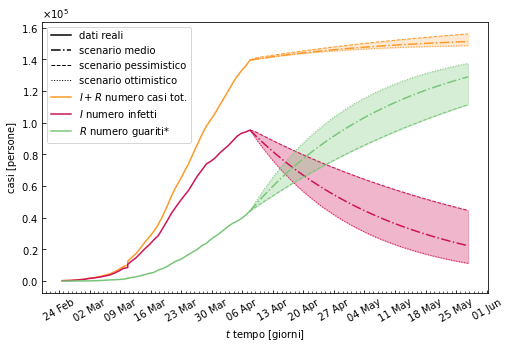

In [16]:
fig2 = plt.figure(figsize=(8,5))
ax = fig2.add_subplot('111')

S_avg, I_avg, R_avg = res_avg.y
S_min, I_min, R_min = res_min.y
S_max, I_max, R_max = res_max.y
t_model_date = df.data.values[0] + (t_model) * np.timedelta64(1*24*60*60, 's')
t_date = df.data.values[0] + (t) * np.timedelta64(1*24*60*60, 's')
# plot casi tottali
ax.fill_between(t_model_date, I_min+R_min, I_max+R_max, lw=1, color='#fe9929', alpha=.2)
ax.plot(t_model_date, I_avg + R_avg, "-.", lw=1.5, color='#fe9929')
ax.plot(t_model_date, I_min + R_min, ":", lw=1, color='#fe9929')
ax.plot(t_model_date, I_max + R_max, "--", lw=1,color='#fe9929')
plot1 = ax.plot(t_date, I+R, lw=1.5, color='#fe9929')
# plot infetti
ax.fill_between(t_model_date, I_min, I_max, lw=1, color='#ce1256', alpha=.3)
ax.plot(t_model_date, I_avg, "-.", lw=1.5, color='#ce1256')
ax.plot(t_model_date, I_min, ":", lw=1, color='#ce1256')
ax.plot(t_model_date, I_max, "--", lw=1,color='#ce1256')
plot2 = ax.plot(t_date, I, lw=1.5, color='#ce1256')
# plot guariti
ax.fill_between(t_model_date, R_min, R_max, lw=1, color='#78c679', alpha=.3)
ax.plot(t_model_date, R_avg, "-.", lw=1.5, color='#78c679')
ax.plot(t_model_date, R_min, ":", lw=1, color='#78c679')
ax.plot(t_model_date, R_max, "--", lw=1,color='#78c679')
plot3 = ax.plot(t_date, R, lw=1.5, color='#78c679')
plot_reali = ax.plot([np.nan], [np.nan], "-", lw=1.5,color='k')
plot_avg = ax.plot([np.nan], [np.nan], "-.", lw=1.5,color='k')
plot_min = ax.plot([np.nan], [np.nan], ":", lw=1,color='k')
plot_max = ax.plot([np.nan], [np.nan], "--", lw=1,color='k')

ax.legend(plot_reali + plot_avg + plot_max + plot_min + plot1+ plot2+ plot3, 
          ["dati reali", "scenario medio", "scenario pessimistico", "scenario ottimistico", 
           "$I+R$ numero casi tot.", "$I$ numero infetti", "$R$ numero guariti*"])
ax.set_xlabel("$t$ tempo [giorni]")
ax.set_ylabel( "casi [persone]")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3),useMathText=True)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax.xaxis.set_minor_locator(DayLocator())
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=0))

plt.show()

### Costruzione funzione generica <a class="anchor" id="s2.3"></a>

In [17]:
import datetime

def print_peak(t, I_max, I_min, I_avg, T_max, T_min, T_avg):
    str_ = "-"*80
    str_ += "\n\tScenario medio:\t\tpicco previsto il " + datetime.datetime.fromtimestamp(t[I_avg == I_avg.max()].tolist()[0] * 1e-9).strftime('%d %B %Y')
    str_ += "\n\t\t\t\ttot casi: %1.3e"%(max(T_avg))
    str_ += "\n\tScenario pessimistico:\tpicco previsto il " + datetime.datetime.fromtimestamp(t[I_max == I_max.max()].tolist()[0] * 1e-9).strftime('%d %B %Y')
    str_ += "\n\t\t\t\ttot casi: %1.3e"%(max(T_max))
    str_ += "\n\tScenario ottimistico:\tpicco previsto il " + datetime.datetime.fromtimestamp(t[I_min == I_min.max()].tolist()[0] * 1e-9).strftime('%d %B %Y')
    str_ += "\n\t\t\t\ttot casi: %1.3e"%(max(T_min))
    str_ += "\n"
    str_ += "-"*80
    return print(str_)

def SIR_model_analysis(t,S,I,R, beta_constant=False, N_days = 60, logscale=False, plot_name=False):
    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot('211')
    ax1_twin = ax1.twinx()
    ax2 = fig.add_subplot('212')
    
    
    t_day = ((t -t[0]) / (24*60*60*1e9)).astype(int) # [d]
    t_day_, dSdt = cent_dif(t_day, S)
    _, dIdt = cent_dif(t_day, I)
    _, dRdt = cent_dif(t_day, R)
    γ = dRdt/I[1:-1]
    β = -dSdt/S[1:-1]/I[1:-1]
    βmin = max(β)/100
    z = 1 # %68 (1.96 %95)
    γ_mean, δγ = [γ.mean(), z*γ.std()]
    N = len(β)
    N_0 = min(N, 17)
    # Calcolo β
    if not beta_constant:
        try:        
            popt_ramp, pcov_ramp = curve_fit(β_ramp, t_day_[-N_0:], β[-N_0:], method='lm', p0=[-1, t_day_.max() + 20])
            m_r, t0_r = popt_ramp
            δm_r, δt0_r = z*np.sqrt(np.diag(pcov_ramp))
        except:
            β_mean, δβ = [β[-N_0:].mean(), z*β[-N_0:].std()]
            beta_constant = True
    else:
        β_mean, δβ = [β[-N_0:].mean(), z*β[-N_0:].std()]

    # plot1: costanti 
    t_plot = np.linspace(0,t_day_[-1]+12)
    t_plot_date = t[0] + (t_plot) * np.timedelta64(1*24*60*60, 's')
    t_day__date = t[0] + (t_day_) * np.timedelta64(1*24*60*60, 's')
    ax1.scatter(t_day__date, β, s=40, fc='None', ec='#2171b5')
    ax1_twin.scatter(t_day__date, γ, s=40, fc='None', marker='s', ec='#ce1256')
    
    if not beta_constant:
        ax1.plot(t_plot_date, β_ramp(t_plot, m_r, t0_r), lw=1, color='#2171b5')
        ax1.fill_between(t_plot_date, β_ramp(t_plot, m_r+δm_r, t0_r-δt0_r), β_ramp(t_plot, m_r-δm_r, t0_r+δt0_r),
                        lw=1, color='#2171b5', alpha=.3)
    else:
        ax1.plot(t_plot_date, β_ramp(t_plot, 0, 0, constant=β_mean), lw=1, color='#2171b5')
        ax1.fill_between(t_plot_date, β_ramp(t_plot, 0, 0, constant=β_mean-δβ), β_ramp(t_plot, 0, 0, constant=β_mean+δβ),
                        lw=1, color='#2171b5', alpha=.3)
    ax1_twin.plot(t_plot_date[[0,-1]], [γ_mean, γ_mean], lw=1, color='#ce1256')
    ax1_twin.fill_between(t_plot_date[[0,-1]], [γ_mean-δγ, γ_mean-δγ], [γ_mean+δγ, γ_mean+δγ], lw=1, color='#ce1256',
                         alpha=.25)

    ax1.set_ylabel('β Tasso di infettività')
    ax1.set_xlabel("$t$ tempo [giorni]")
    ax1.yaxis.label.set_color('#2171b5')
    ax1.spines["left"].set_edgecolor('#2171b5')
    ax1_twin.spines["left"].set_edgecolor('#2171b5')
    ax1.tick_params(axis='y', colors='#2171b5')
    ax1_twin.set_ylim([-0.03,0.11])
    ax1_twin.set_ylabel('γ Tasso di guarigione')
    ax1_twin.yaxis.label.set_color('#ce1256')
    ax1_twin.spines["right"].set_edgecolor('#ce1256')
    ax1_twin.tick_params(axis='y', colors='#ce1256')
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(-3,3),useMathText=True)
    ax1_twin.ticklabel_format(axis='y', style='sci', scilimits=(-3,3),useMathText=True)
    formatter = DateFormatter('%d %b')
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax1.xaxis.set_minor_locator(DayLocator())
    ax1.xaxis.set_major_locator(WeekdayLocator(byweekday=0))
    
    # Scenari modello SIR
    t_span = [t_day[-1], t_day[-1]+N_days]
    t_model = np.linspace(t_span[0], t_span[-1], 2*N_days+1)
    y0 = [S[-1], I[-1], R[-1]]
    if not beta_constant:
        res_avg = solve_ivp(dvdt_SIR, t_span, y0, t_eval=t_model, args=[m_r, t0_r, γ_mean, False, βmin])
        res_min = solve_ivp(dvdt_SIR, t_span, y0, t_eval=t_model, args=[m_r+δm_r, t0_r-δt0_r, γ_mean+δγ, False, βmin])
        res_max = solve_ivp(dvdt_SIR, t_span, y0, t_eval=t_model, args=[m_r-δm_r, t0_r+δt0_r, np.max([1e-5, γ_mean-δγ]), False, βmin])
    else: 
        res_avg = solve_ivp(dvdt_SIR, t_span, y0, t_eval=t_model, args=[0, 0, γ_mean, β_mean, βmin])
        res_min = solve_ivp(dvdt_SIR, t_span, y0, t_eval=t_model, args=[0, 0, γ_mean+δγ, np.max([1e-11, β_mean-δβ]), βmin])
        res_max = solve_ivp(dvdt_SIR, t_span, y0, t_eval=t_model, args=[0, 0, np.max([1e-5, γ_mean-δγ]), β_mean+δβ, βmin])
    
    S_avg, I_avg, R_avg = res_avg.y
    S_min, I_min, R_min = res_min.y
    S_max, I_max, R_max = res_max.y
    t_model_date = t[-1] + (t_model - t_model[0]) * np.timedelta64(1*24*60*60, 's')
    # plot casi tottali
    T, T_avg, T_min, T_max = [I+R, I_avg + R_avg, I_min + R_min, I_max + R_max]
    ax2.fill_between(t_model_date, T_min, T_max, lw=1, color='#fe9929', alpha=.2)
    ax2.plot(t_model_date, T_avg, "-.", lw=1.5, color='#fe9929')
    ax2.plot(t_model_date, T_min, ":", lw=1, color='#fe9929')
    ax2.plot(t_model_date, T_max, "--", lw=1,color='#fe9929')
    plot1 = ax2.plot(t, I+R, lw=1.5, color='#fe9929')
    # plot infetti
    ax2.fill_between(t_model_date, I_min, I_max, lw=1, color='#ce1256', alpha=.3)
    ax2.plot(t_model_date, I_avg, "-.", lw=1.5, color='#ce1256')
    ax2.plot(t_model_date, I_min, ":", lw=1, color='#ce1256')
    ax2.plot(t_model_date, I_max, "--", lw=1,color='#ce1256')
    plot2 = ax2.plot(t, I, lw=1.5, color='#ce1256')
    # plot guariti
    ax2.fill_between(t_model_date, R_min, R_max, lw=1, color='#78c679', alpha=.3)
    ax2.plot(t_model_date, R_avg, "-.", lw=1.5, color='#78c679')
    ax2.plot(t_model_date, R_min, ":", lw=1, color='#78c679')
    ax2.plot(t_model_date, R_max, "--", lw=1,color='#78c679')
    plot3 = ax2.plot(t, R, lw=1.5, color='#78c679')
    plot_reali = ax2.plot([np.nan], [np.nan], "-", lw=1.5,color='k')
    plot_avg = ax2.plot([np.nan], [np.nan], "-.", lw=1.5,color='k')
    plot_min = ax2.plot([np.nan], [np.nan], ":", lw=1,color='k')
    plot_max = ax2.plot([np.nan], [np.nan], "--", lw=1,color='k')

    ax2.legend(plot_reali + plot_avg + plot_max + plot_min + plot1+ plot2+ plot3, 
              ["dati reali", "scenario medio", "scenario pessimistico", "scenario ottimistico", 
               "$I+R$ numero casi tot.", "$I$ numero infetti", "$R$ numero guariti*"])
    ax2.set_xlabel("$t$ tempo [giorni]")
    ax2.set_ylabel( "casi [persone]")
    ax2.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax2.xaxis.set_minor_locator(DayLocator())
    ax2.xaxis.set_major_locator(WeekdayLocator(byweekday=0))
    
    if logscale : 
        ax2.set_yscale('log')
    else:
        ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,3),useMathText=True)
        if (max(T_max) / max(T)) > 20:
            ax2.set_ylim([-0.05*max(T), 2*max(T)])
    
    t_mode_date = t[-1] + (t_model-t_model[0]) * np.timedelta64(1*24*60*60, 's')
    print_peak(t_mode_date, I_max, I_min, I_avg,  T_max, T_min, T_avg)
    if plot_name:
        fig.savefig('plot_%s.png' % plot_name, dpi=400)
    

    plt.show()
    
        

## Applicazione all' Italia  <a class="anchor" id="s3"></a>

--------------------------------------------------------------------------------
	Scenario medio:		picco previsto il 08 April 2020
				tot casi: 1.581e+05
	Scenario pessimistico:	picco previsto il 11 April 2020
				tot casi: 1.670e+05
	Scenario ottimistico:	picco previsto il 08 April 2020
				tot casi: 1.525e+05
--------------------------------------------------------------------------------


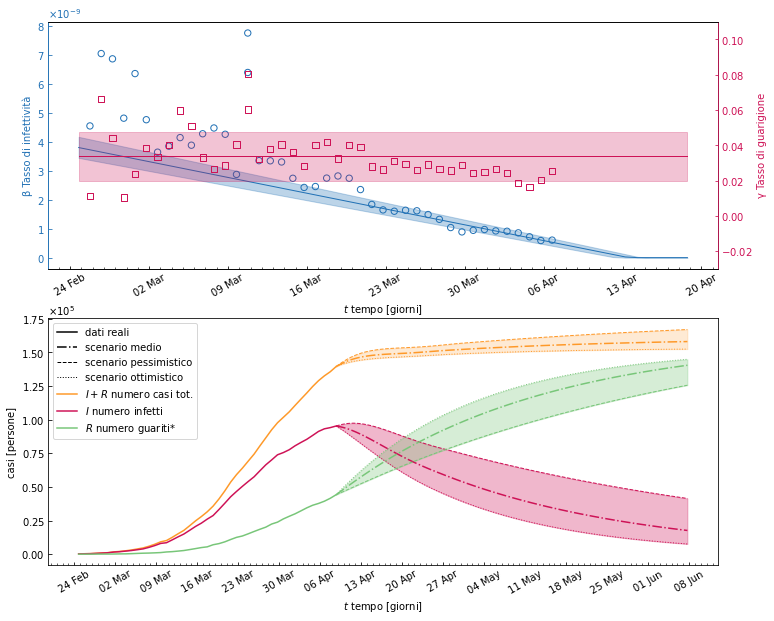

In [18]:
SIR_model_analysis(df.data.values,S,I,R, plot_name="ITA")

## Applicazione al Mondo  <a class="anchor" id="s4"></a>

In [19]:
N_W = 7713468000   # Popolazione mondiale 2019 [source: UN]
N_PRC = 1433783686 # Popolazione china
cautries = df_jhu_R.columns.values
t_W = df_jhu_T.index.values
R_W = df_jhu_R.values[:, cautries != "China"].sum(axis=1) + df_jhu_D.values[:, cautries != "China"].sum(axis=1)
I_W = df_jhu_T.values[:, cautries != "China"].sum(axis=1) - R_W
S_W = N_W- N_PRC - R_W - I_W
index = np.where(I_W>5000)

--------------------------------------------------------------------------------
	Scenario medio:		picco previsto il 14 July 2020
				tot casi: 5.873e+09
	Scenario pessimistico:	picco previsto il 23 June 2020
				tot casi: 6.242e+09
	Scenario ottimistico:	picco previsto il 04 August 2020
				tot casi: 2.572e+09
--------------------------------------------------------------------------------


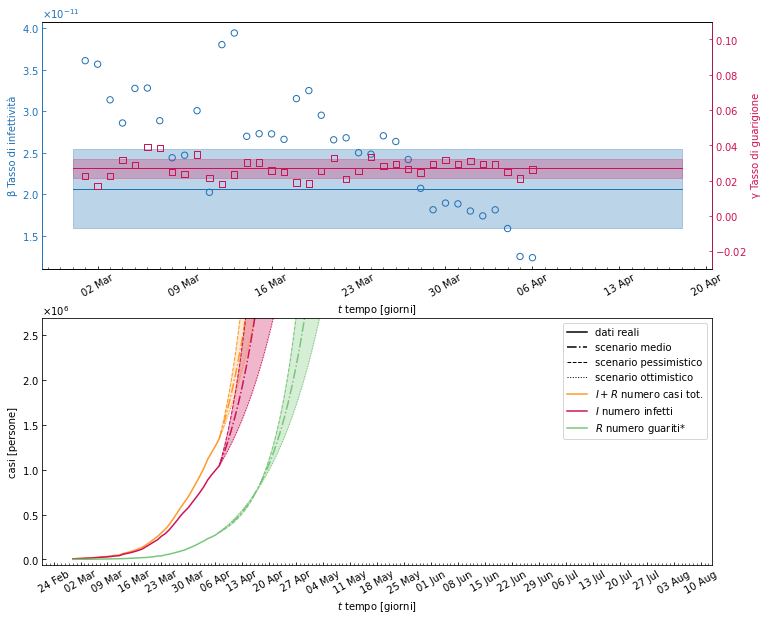

In [20]:
SIR_model_analysis(t_W[index],S_W[index],I_W[index],R_W[index], beta_constant=True, N_days =120, plot_name="WRD")

## Applicazione agli USA <a class="anchor" id="s5"></a>

In [21]:
N_US = 329311764   # Popolazione US 2019 
cautries = df_jhu_R.columns.values
t_US = df_jhu_T.index.values
R_US = df_jhu_R.values[:, cautries == "US"] + df_jhu_D.values[:, cautries == "US"]
I_US = df_jhu_T.values[:, cautries == "US"] - R_US
S_US = N_US - R_US - I_US
index, _ = np.where(I_US>100)

--------------------------------------------------------------------------------
	Scenario medio:		picco previsto il 11 April 2020
				tot casi: 5.605e+05
	Scenario pessimistico:	picco previsto il 05 June 2020
				tot casi: 6.404e+05
	Scenario ottimistico:	picco previsto il 10 April 2020
				tot casi: 5.252e+05
--------------------------------------------------------------------------------


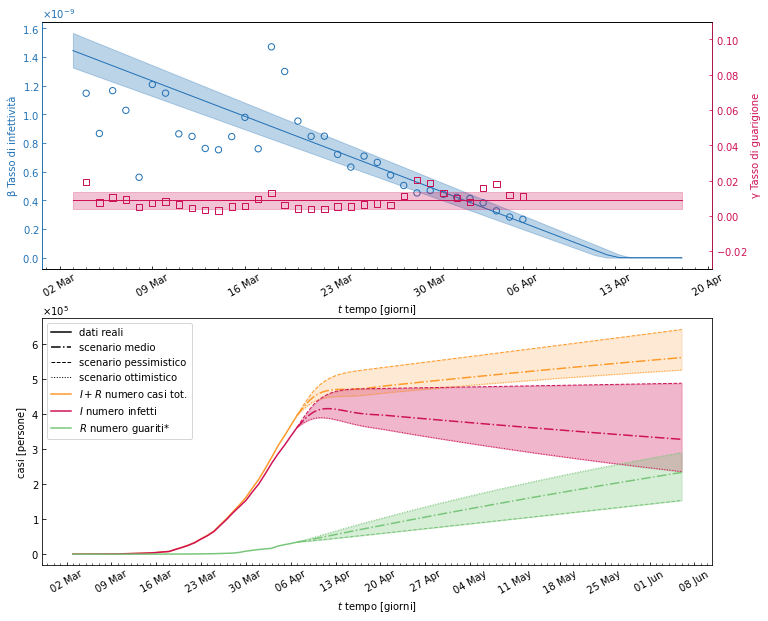

In [22]:
SIR_model_analysis(t_US[index],S_US[index,0],I_US[index,0],R_US[index,0], beta_constant=False, N_days =60, logscale=False, plot_name="USA")